# IsolationForestDetect Example

In this example, we will explore how to predict anomalies within a dataset using the IsolationForest 
algorithm which isolates observations by randomly selecting a feature and then randomly 
selecting a split value between the maximum and minimum values of the selected feature.
This subclass uses the `sklearn.ensemble.IsolationForest` class from `sklearn` in the
background.

`sklearn.ensemble.IsolationForest` can only handle numerical data, however, this subclass allows for categorical
input by applying ordinal encoding before calling the sklearn class. In order to use this function,
use enable_encoder=True. If you'd like to use a different type of encoding, 
consider using the Pipeline class and call your own encoder before calling this subclass.
For more details see [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#).

In [346]:
import sys
sys.path.append('../../../notebooks')

import pandas as pd
import numpy as np
from raimitigations.datadiagnostics import IsolationForestDetect
from download import download_datasets
from itertools import compress
import random
import string

import warnings
warnings.filterwarnings('ignore')

random.seed(42)
np.random.seed(42)

Load the data:

In [347]:
data_dir = '../../../datasets/'
download_datasets(data_dir)
dataset = pd.read_csv(data_dir + 'hr_promotion/train.csv')
dataset = dataset[:10000].dropna(axis=0).drop('employee_id', axis=1).reset_index().drop('index', axis=1)

dataset

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,Procurement,region_13,Master's & above,f,other,1,37,4.0,7,1,0,71,0
8851,Sales & Marketing,region_33,Master's & above,m,sourcing,1,39,3.0,7,0,0,48,0
8852,Finance,region_13,Master's & above,f,sourcing,1,33,4.0,4,1,0,58,0
8853,Operations,region_28,Master's & above,m,other,1,32,4.0,4,1,0,57,1


This class uses a `.fit()`, `.predict()` and `.transform()` interface. It uses a `col_predict` parameter to specify the columns to be included in error prediction, if `None`, all columns will be evaluated for errors. It also uses a `mode` string parameter that can take the values:
- `"column"`: fit and prediction will be applied to each column independently. An error matrix of the same shape as the data will be returned by `predict`.
- `"row"`: fit is applied over the whole data and prediction over each row. A list of erroneous row indices will be returned by `predict`.

Given the setting `mode`=`"column"`, `.predict()` returns a matrix of the same shape as the input data indicating if an element is erroneous: -1, non-erroneous: +1 or np.nan for columns not included in `col_predict`.

We can use the following function to print out erroneous values returned by the error matrix:

In [348]:
def print_erroneous_values_per_column(df, error_matrix):
    for i, column in enumerate(df):
        mask = np.where(error_matrix == -1, True, False)
        errors = set(compress(list(df[column]), mask[:, i]))
        if errors:
            print("Column: ", column)
            print(list(errors))

In [349]:
def check_synthetic_outliers_detected_column(df, error_matrix, outliers_dict):
    undetected_outliers = {}
    detected_outliers = {}
    for i, column in enumerate(df):
        mask = np.where(error_matrix == -1, True, False)
        errors = set(compress(list(df[column]), mask[:, i]))
        if errors:
            if column in outliers_dict:
                for value in outliers_dict[column]:
                    if value in errors:
                        if column not in detected_outliers:
                            detected_outliers[column] = []
                        detected_outliers[column].append(value)
                    else:
                        if column not in undetected_outliers:
                            undetected_outliers[column] = []
                        undetected_outliers[column].append(value)
        else:
            if column in outliers_dict:
                undetected_outliers[column] = list(outliers_dict[column])
    if undetected_outliers:
        print("The following outliers were NOT detected in the erroneous rows for the corresponding columns:\n")
        for column, values in undetected_outliers.items():
            print(f"{column}: {values}")
    if detected_outliers:
        print("\nThe following outliers were detected in the erroneous rows for the corresponding columns:\n")
        for column, values in detected_outliers.items():
            print(f"{column}: {values}")
    print("\n-----------------------------\n")

In [350]:
def check_synthetic_outliers_detected_row(df, erroneous_rows, outliers_dict):
    undetected_outliers = {}
    detected_outliers = {}
    for column, outliers in outliers_dict.items():
        for value in outliers:
            found = False
            for index in erroneous_rows:
                if value == df.loc[index, column]:
                    found = True
                    break
            if found:
                if column not in detected_outliers:
                    detected_outliers[column] = []
                detected_outliers[column].append(value)
            else:
                if column not in undetected_outliers:
                    undetected_outliers[column] = []
                undetected_outliers[column].append(value)

    if undetected_outliers:
        print("The following outliers were NOT detected in the erroneous rows for the corresponding columns:\n")
        for column, values in undetected_outliers.items():
            print(f"{column}: {values}")
    if detected_outliers:
        print("\nThe following outliers were detected in the erroneous rows for the corresponding columns:\n")
        for column, values in detected_outliers.items():
            print(f"{column}: {values}")
    print("\n-----------------------------\n")

#### Dataset Edit
Datasets tend to naturally have errors in them and this dataset is no different. However, in addition to existing errors, for the sake of this tutorial, we will inject some synthetic outliers to help highlight functionalities offered by `IsolationForestDetect`.

In [351]:
def get_random_indices(df: pd.DataFrame, size: int) -> list:
    indices = df.index.to_list()
    return random.sample(indices, size)

In [352]:
numerical_columns = list(dataset.select_dtypes(include=['number']).columns)
categorical_columns = list(set(list(dataset))-set(numerical_columns))

In [353]:
synthetic_outliers={}
def append_synthetic_outliers(synthetic_outliers_dict, column, outlier):
    if column not in synthetic_outliers_dict:
        synthetic_outliers_dict[column] = set()
    synthetic_outliers_dict[column].add(outlier)
    return synthetic_outliers_dict

In [354]:
# injecting random values
rand_indices = get_random_indices(dataset, 10)
for index in rand_indices:
    column = np.random.choice(numerical_columns)
    mean = dataset[column].mean()
    std_dev = dataset[column].std()
    outlier = np.random.choice([mean - 4 * std_dev, mean + 4 * std_dev])
    dataset.at[index, column] = outlier
    append_synthetic_outliers(synthetic_outliers, column, outlier)
    print("column: ", column, "; outlier: ", outlier)

column:  avg_training_score ; outlier:  117.47971917329522
column:  KPIs_met >80% ; outlier:  -1.5597340269076336
column:  previous_year_rating ; outlier:  8.365703973833686
column:  KPIs_met >80% ; outlier:  -1.5615605053124915
column:  avg_training_score ; outlier:  117.5312748043361
column:  previous_year_rating ; outlier:  -1.6581673717621652
column:  previous_year_rating ; outlier:  -1.6629606123281913
column:  is_promoted ; outlier:  -1.0617178912195158
column:  length_of_service ; outlier:  23.266773848505803
column:  is_promoted ; outlier:  -1.0628726336695264


In [355]:
# injecting extreme values
rand_indices = get_random_indices(dataset, 10)
for index in rand_indices:
    column = np.random.choice(numerical_columns)
    extreme_value = 100 * dataset.at[index, column]
    dataset.at[index, column] = extreme_value
    append_synthetic_outliers(synthetic_outliers, column, extreme_value)
    print("column: ", column, "; outlier: ", extreme_value)


column:  awards_won? ; outlier:  0
column:  KPIs_met >80% ; outlier:  0.0
column:  age ; outlier:  3800
column:  is_promoted ; outlier:  100.0
column:  length_of_service ; outlier:  300.0
column:  awards_won? ; outlier:  0
column:  awards_won? ; outlier:  0
column:  age ; outlier:  3100
column:  is_promoted ; outlier:  100.0
column:  length_of_service ; outlier:  400.0


In [356]:
# injecting inverted values
rand_indices = get_random_indices(dataset, 10)
for index in rand_indices:
    column = np.random.choice(numerical_columns)
    inverted_value = -1 * dataset.at[index, column]
    dataset.at[index, column] = inverted_value
    append_synthetic_outliers(synthetic_outliers, column, inverted_value)
    print("column: ", column, "; outlier: ", inverted_value)

column:  KPIs_met >80% ; outlier:  -0.0
column:  no_of_trainings ; outlier:  -1
column:  length_of_service ; outlier:  -11.0
column:  age ; outlier:  -36
column:  awards_won? ; outlier:  0
column:  KPIs_met >80% ; outlier:  -1.0
column:  length_of_service ; outlier:  -16.0
column:  no_of_trainings ; outlier:  -1
column:  no_of_trainings ; outlier:  -3
column:  previous_year_rating ; outlier:  -3.0


In [357]:
rand_indices = get_random_indices(dataset, 4)
education_outliers = ["not an education status 1", "not an education status 2", "not an education status 3", "not an education status 4"]
synthetic_outliers["education"] = education_outliers
dataset.loc[rand_indices, "education"] = education_outliers

In [358]:
synthetic_outliers

{'avg_training_score': {117.47971917329522, 117.5312748043361},
 'KPIs_met >80%': {-1.5615605053124915, -1.5597340269076336, -1.0, 0.0},
 'previous_year_rating': {-3.0,
  -1.6629606123281913,
  -1.6581673717621652,
  8.365703973833686},
 'is_promoted': {-1.0628726336695264, -1.0617178912195158, 100.0},
 'length_of_service': {-16.0, -11.0, 23.266773848505803, 300.0, 400.0},
 'awards_won?': {0},
 'age': {-36, 3100, 3800},
 'no_of_trainings': {-3, -1},
 'education': ['not an education status 1',
  'not an education status 2',
  'not an education status 3',
  'not an education status 4']}

#### `mode`=`"row"`:

Using the default setting, `enable_encoder`=False, categorical columns will be excluded from anomaly detection:

In [359]:
isf_detector_1 = IsolationForestDetect(
    df=dataset,
    col_predict=numerical_columns,
    mode="row",
    isf_params={
        "n_estimators": 100,
        "max_samples": "auto",
        "contamination": "auto",
        "max_features": 1.0,
        "bootstrap": False,
        "n_jobs": None,
        "random_state": 0,
        "warm_start": False,
    },
    enable_encoder = False,
    verbose=False,
)
isf_detector_1.fit()
indices = isf_detector_1.predict(dataset)
check_synthetic_outliers_detected_row(dataset, indices, synthetic_outliers)
len(indices)

The following outliers were NOT detected in the erroneous rows for the corresponding columns:

avg_training_score: [117.47971917329522]
KPIs_met >80%: [-1.0, -1.5597340269076336]
previous_year_rating: [8.365703973833686, -1.6629606123281913]
is_promoted: [-1.0628726336695264, -1.0617178912195158]
length_of_service: [-16.0, -11.0]
age: [3100]
no_of_trainings: [-3, -1]
education: ['not an education status 1', 'not an education status 3', 'not an education status 4']

The following outliers were detected in the erroneous rows for the corresponding columns:

avg_training_score: [117.5312748043361]
KPIs_met >80%: [0.0, -1.5615605053124915]
previous_year_rating: [-3.0, -1.6581673717621652]
is_promoted: [100.0]
length_of_service: [300.0, 400.0, 23.266773848505803]
awards_won?: [0]
age: [3800, -36]
education: ['not an education status 2']

-----------------------------



2027

Now, using `enable_encoder`=True, we can use `col_predict`=None and include all columns in the anomaly detection by default. 

We also have the option for further cutomization:
- We can pass an `sklearn.IsolationForest` object directly, note that in this case, `isf_params` will be ignored.
- We can save our prediction results to a log file using the parameter `save_json`. This parameter defaults to None, where no log file is saved. Given `mode`="row", the log file will include:
    - "object_config": contains set attributes of the concrete class;
    - "erroneous_rows": containing a list of erroneous row indices.

In [360]:
from sklearn.ensemble import IsolationForest
sklearn_obj = clf = IsolationForest(random_state=100, contamination=0.05)
isf_detector_2 = IsolationForestDetect(
    df=dataset,
    col_predict=None,
    sklearn_obj=sklearn_obj,
    enable_encoder = True,
    save_json='../logs/log_2.json',
    verbose=False,
)
isf_detector_2.fit()
indices = isf_detector_2.predict(dataset)
check_synthetic_outliers_detected_row(dataset, indices, synthetic_outliers)
len(indices)

The following outliers were NOT detected in the erroneous rows for the corresponding columns:

avg_training_score: [117.5312748043361, 117.47971917329522]
KPIs_met >80%: [-1.5615605053124915, -1.0, -1.5597340269076336]
previous_year_rating: [8.365703973833686, -1.6629606123281913, -3.0, -1.6581673717621652]
is_promoted: [-1.0628726336695264, -1.0617178912195158]
length_of_service: [300.0, 400.0, -16.0, -11.0, 23.266773848505803]
age: [3800, -36, 3100]
no_of_trainings: [-3, -1]
education: ['not an education status 1', 'not an education status 2', 'not an education status 3', 'not an education status 4']

The following outliers were detected in the erroneous rows for the corresponding columns:

KPIs_met >80%: [0.0]
is_promoted: [100.0]
awards_won?: [0]

-----------------------------



443

We can call the `transform()` method to remove erroneous indices with `mode`=`"row"`:

In [361]:
isf_detector_2.transform(dataset)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8.0,1.0,0,49.0,0.0
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4.0,0.0,0,60.0,0.0
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7.0,0.0,0,50.0,0.0
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10.0,0.0,0,50.0,0.0
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2.0,0.0,0,73.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8407,Procurement,region_13,Master's & above,f,other,1,37,4.0,7.0,1.0,0,71.0,0.0
8408,Sales & Marketing,region_33,Master's & above,m,sourcing,1,39,3.0,7.0,0.0,0,48.0,0.0
8409,Finance,region_13,Master's & above,f,sourcing,1,33,4.0,4.0,1.0,0,58.0,0.0
8410,Operations,region_28,Master's & above,m,other,1,32,4.0,4.0,1.0,0,57.0,1.0


#### `mode`=`"column"`:

Using the default setting, `enable_encoder`=False again, categorical columns will be excluded from anomaly detection:

In [362]:
isf_detector_3 = IsolationForestDetect(
    df=dataset,
    col_predict=['no_of_trainings','previous_year_rating','length_of_service',
                 'KPIs_met >80%','awards_won?'],
    mode="column",
    isf_params={
        "n_estimators": 100,
        "max_samples": "auto",
        "contamination": "auto",
        "max_features": 1.0,
        "bootstrap": False,
        "n_jobs": None,
        "random_state": 0,
        "warm_start": False,
    },
    enable_encoder=False,
    verbose=False,
)
isf_detector_3.fit()
error_matrix = isf_detector_3.predict(dataset)
check_synthetic_outliers_detected_column(dataset[['no_of_trainings','previous_year_rating','length_of_service',
                 'KPIs_met >80%','awards_won?']], error_matrix, synthetic_outliers)
print_erroneous_values_per_column(dataset, error_matrix)

The following outliers were NOT detected in the erroneous rows for the corresponding columns:

no_of_trainings: [-3, -1]
previous_year_rating: [8.365703973833686, -1.6629606123281913, -3.0, -1.6581673717621652]
length_of_service: [300.0, 400.0, -16.0, -11.0, 23.266773848505803]
KPIs_met >80%: [0.0, -1.5615605053124915, -1.0, -1.5597340269076336]
awards_won?: [0]

-----------------------------

Column:  no_of_trainings
[2, 3, 4, 5, 6, 7, 8, 10]
Column:  previous_year_rating
[1.0, 2.0, 4.0, 5.0, 8.365703973833686, -1.6581673717621652, -3.0, -1.6629606123281913]
Column:  length_of_service
[1.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 23.266773848505803, 33.0, 34.0, 32.0, 300.0, 400.0, -16.0, -11.0]
Column:  KPIs_met >80%
[1.0, -1.5615605053124915, -1.0, -1.5597340269076336]
Column:  awards_won?
[1]


And now with enabling encoding, we can include categorical columns. Let's also add a log file path, given `mode`="column", the log file will include:
- "object_config": contains set attributes of the concrete class;
- It maps every column containing errors to a list of its erroneous values.

In [363]:
isf_detector_4 = IsolationForestDetect(
    df=dataset,
    col_predict=['education', 'recruitment_channel',
                 'no_of_trainings', 'previous_year_rating', 'length_of_service',
                 'KPIs_met >80%', 'awards_won?'],
    mode="column",
    isf_params={
        "n_estimators": 100,
        "max_samples": "auto",
        "contamination": "auto",
        "max_features": 1.0,
        "bootstrap": False,
        "n_jobs": None,
        "random_state": 0,
        "warm_start": False,
    },
    enable_encoder=True,
    save_json='../logs/log_4.json',
    verbose=False,
)
isf_detector_4.fit()
error_matrix = isf_detector_4.predict(dataset)
check_synthetic_outliers_detected_column(dataset[['education', 'recruitment_channel',
                 'no_of_trainings', 'previous_year_rating', 'length_of_service',
                 'KPIs_met >80%', 'awards_won?']], error_matrix, synthetic_outliers)
print_erroneous_values_per_column(dataset, error_matrix)

The following outliers were NOT detected in the erroneous rows for the corresponding columns:

education: ['not an education status 1', 'not an education status 2', 'not an education status 3', 'not an education status 4']
no_of_trainings: [-3]
previous_year_rating: [8.365703973833686, -1.6629606123281913, -3.0, -1.6581673717621652]
length_of_service: [300.0, 400.0, -11.0, 23.266773848505803]
KPIs_met >80%: [-1.5615605053124915, -1.0, -1.5597340269076336]
awards_won?: [0]

The following outliers were detected in the erroneous rows for the corresponding columns:

no_of_trainings: [-1]
length_of_service: [-16.0]
KPIs_met >80%: [0.0]

-----------------------------

Column:  education
['not an education status 1', "Master's & above", 'not an education status 2', 'not an education status 4', 'not an education status 3', 'Below Secondary']
Column:  recruitment_channel
['referred', 'sourcing']
Column:  no_of_trainings
[2, 3, 4, 5, 6, 7, 8, 10]
Column:  previous_year_rating
[1.0, 2.0, 4.0, 5.0

In [364]:
error_matrix

array([[nan, nan, -1., ...,  1., nan, nan],
       [nan, nan,  1., ...,  1., nan, nan],
       [nan, nan,  1., ...,  1., nan, nan],
       ...,
       [nan, nan, -1., ...,  1., nan, nan],
       [nan, nan, -1., ...,  1., nan, nan],
       [nan, nan,  1., ...,  1., nan, nan]])

We can call the `.transform()` function to transform the data, using `mode`=`"column"`, we have the 2 following options:
1. Remove erroneous values from the data:

In [365]:
isf_detector_4.transform(dataset)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,NaN,f,NaN,1.0,35,NaN,8.0,NaN,0.0,49.0,0.0
1,Operations,region_22,Bachelor's,m,other,1.0,30,NaN,4.0,0.0,0.0,60.0,0.0
2,Sales & Marketing,region_19,Bachelor's,m,NaN,1.0,34,3.0,7.0,0.0,0.0,50.0,0.0
3,Sales & Marketing,region_23,Bachelor's,m,other,NaN,39,NaN,NaN,0.0,0.0,50.0,0.0
4,Technology,region_26,Bachelor's,m,other,1.0,45,3.0,2.0,0.0,0.0,73.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,Procurement,region_13,NaN,f,other,1.0,37,NaN,7.0,NaN,0.0,71.0,0.0
8851,Sales & Marketing,region_33,NaN,m,NaN,1.0,39,3.0,7.0,0.0,0.0,48.0,0.0
8852,Finance,region_13,NaN,f,NaN,1.0,33,NaN,4.0,NaN,0.0,58.0,0.0
8853,Operations,region_28,NaN,m,other,1.0,32,NaN,4.0,NaN,0.0,57.0,1.0


2. Or, we can pass an imputer to impute these values post removal. Here we are using the `IterativeDataImputer` offered by this library:

In [366]:
from raimitigations.dataprocessing import IterativeDataImputer
from sklearn.ensemble import RandomForestRegressor
imputer = IterativeDataImputer(
    df=dataset,
    col_impute=None,
    enable_encoder=True,
    iterative_params={
        'estimator': RandomForestRegressor(),
        'missing_values': np.nan,
        'sample_posterior': False,
        'max_iter': 3,
        'tol': 1e-3,
        'n_nearest_features': None,
        'initial_strategy': 'mean',
        'imputation_order': 'ascending',
        'skip_complete': False,
        'min_value': -np.inf,
        'max_value': np.inf,
        'random_state': 100},
    verbose=False
)

isf_detector_4.transform(dataset, imputer=imputer)

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,Sales & Marketing,region_7,Bachelor's,f,other,1.0,35.0,3.0,8.000,0.0,0.0,49.0,0.0
1,Operations,region_22,Bachelor's,m,other,1.0,30.0,3.0,4.000,0.0,0.0,60.0,0.0
2,Sales & Marketing,region_19,Bachelor's,m,other,1.0,34.0,3.0,7.000,0.0,0.0,50.0,0.0
3,Sales & Marketing,region_23,Bachelor's,m,other,1.0,39.0,3.0,5.875,0.0,0.0,50.0,0.0
4,Technology,region_26,Bachelor's,m,other,1.0,45.0,3.0,2.000,0.0,0.0,73.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8850,Procurement,region_13,Bachelor's,f,other,1.0,37.0,3.0,7.000,0.0,0.0,71.0,0.0
8851,Sales & Marketing,region_33,Bachelor's,m,other,1.0,39.0,3.0,7.000,0.0,0.0,48.0,0.0
8852,Finance,region_13,Bachelor's,f,other,1.0,33.0,3.0,4.000,0.0,0.0,58.0,0.0
8853,Operations,region_28,Bachelor's,m,other,1.0,32.0,3.0,4.000,0.0,0.0,57.0,1.0


### Anomaly Visualization

We can use a t-Distributed Stochastic Neighbor Embedding (t-SNE) dimensionality reduction technique to project the anomaly detection data into a 2D space, making it easier to visualize the anomaly distribution.

In [367]:
erroneous_indices = isf_detector_2.predict(dataset)

In [368]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def visualize_anomalies(df, erroneous_rows):
    # Encode categorical variables
    one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded_data = one_hot_encoder.fit_transform(df)

    # Perform dimensionality reduction using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    reduced_data = tsne.fit_transform(encoded_data)

    # Create a boolean mask for erroneous rows
    mask = np.zeros(len(df), dtype=bool)
    mask[erroneous_rows] = True

    # Plot the t-SNE visualization
    plt.scatter(reduced_data[~mask, 0], reduced_data[~mask, 1], c='b', label='Normal')
    plt.scatter(reduced_data[mask, 0], reduced_data[mask, 1], c='g', label='Anomaly', alpha=0.5)
    plt.xlabel('t-SNE Component1')
    plt.ylabel('t-SNE Component2')
    plt.legend()
    plt.title('t-SNE Visualization of Anomaly Detection')
    plt.show()

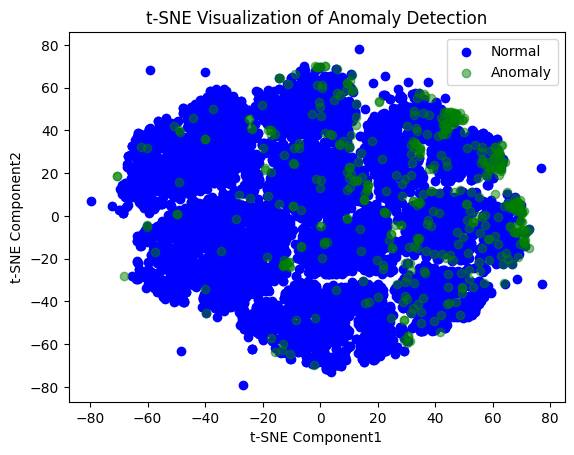

In [369]:
visualize_anomalies(dataset, erroneous_indices)

Let's play with the `contamination` param of sklearn's IsolationForest (previously = 0.05):

443


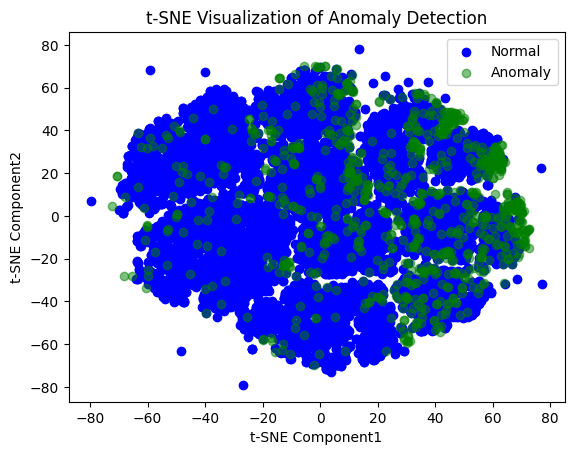

In [370]:
from sklearn.ensemble import IsolationForest
sklearn_obj = clf = IsolationForest(random_state=100, contamination=0.1)
isf_detector_test = IsolationForestDetect(
    df=dataset,
    col_predict=None,
    sklearn_obj=sklearn_obj,
    enable_encoder=True,
    verbose=False,
)
isf_detector_test.fit()
erroneous_indices = isf_detector_test.predict(dataset)
print(len(indices))
visualize_anomalies(dataset, erroneous_indices)

443


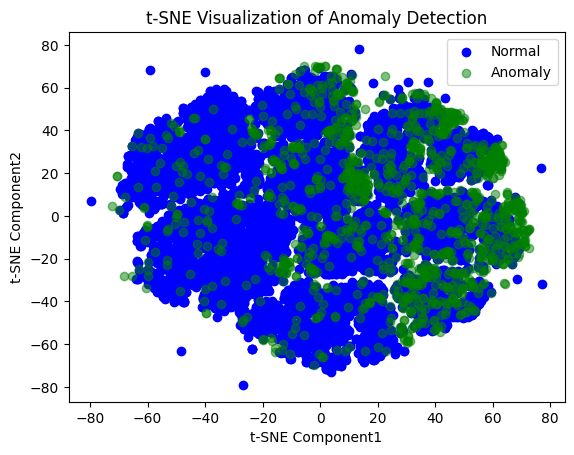

In [371]:
from sklearn.ensemble import IsolationForest
sklearn_obj = clf = IsolationForest(random_state=100, contamination=0.15)
isf_detector_test = IsolationForestDetect(
    df=dataset,
    col_predict=None,
    sklearn_obj=sklearn_obj,
    enable_encoder=True,
    verbose=False,
)
isf_detector_test.fit()
erroneous_indices = isf_detector_test.predict(dataset)
print(len(indices))
visualize_anomalies(dataset, erroneous_indices)


443


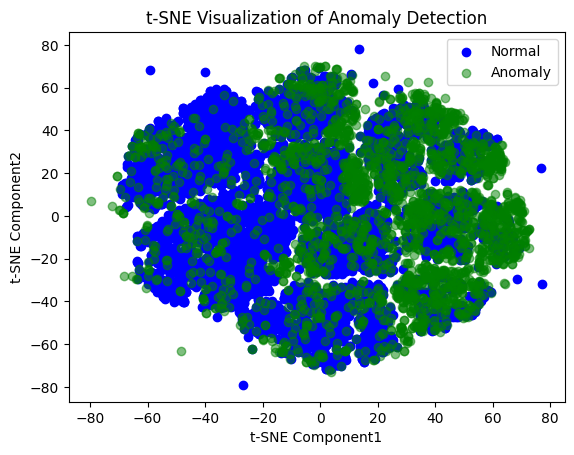

In [372]:
from sklearn.ensemble import IsolationForest
sklearn_obj = clf = IsolationForest(random_state=100, contamination=0.3)
isf_detector_test = IsolationForestDetect(
    df=dataset,
    col_predict=None,
    sklearn_obj=sklearn_obj,
    enable_encoder=True,
    verbose=False,
)
isf_detector_test.fit()
erroneous_indices = isf_detector_test.predict(dataset)
print(len(indices))
visualize_anomalies(dataset, erroneous_indices)